# imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
import pandas as pd
from torch.optim import lr_scheduler
import time
from utils import forward_selection, SI_evaluation

In [2]:
### SETTINGS

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
batch_size = 128
NUM_EPOCHS = 50
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [6]:
t = transforms.Compose([
                       transforms.ToTensor()]
                       )

In [7]:
cifar_train = torchvision.datasets.CIFAR100(root = './CIFAR100/' , train = True , download = True , transform = t)
cifar_split = torchvision.datasets.CIFAR100(root = './CIFAR100/' , train = False , download = True , transform = t)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
torch.manual_seed(42)
cifar_val,cifar_test = random_split(cifar_split,(6700,3300))

In [10]:
train_loader = DataLoader(cifar_train,
                          batch_size = batch_size,
                          shuffle = True,
                          num_workers = 4)
val_loader = DataLoader(cifar_val,
                        batch_size = batch_size,
                        shuffle = False,
                        num_workers = 4)
test_loader = DataLoader(cifar_test,
                        batch_size = batch_size,
                        shuffle = False,
                        num_workers = 4)

# model

In [11]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :32, :32]


class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
                nn.Conv2d(3, 32, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(32, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Flatten(),
        )    
        
        self.z_mean = torch.nn.Linear(256, 200)
        self.z_log_var = torch.nn.Linear(256, 200)
        
        self.decoder = nn.Sequential(
                torch.nn.Linear(200, 256),
                Reshape(-1, 64, 2, 2),
                #
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(64, 32, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(32, 3, stride=2, kernel_size=3, padding=1),
                #
                Trim(),  # 3x129x129 -> 3x128x128
                nn.Sigmoid()
                )


    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded

        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def forward(self, x):
        x = self.encoder(x)
        #print(x.shape)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [12]:
model = VAE().cuda(3)

In [13]:
test = torch.Tensor(1,3, 32,32)
test = test.cuda(3)

In [14]:
a, b, c, d = model(test)
d.shape

torch.Size([1, 3, 32, 32])

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  


In [16]:
def train_vae_v1(num_epochs, model, optimizer, device, 
                 train_loader, loss_fn=None,
                 logging_interval=100, 
                 skip_epoch_stats=False,
                 reconstruction_term_weight=1,
                 save_model=None):
    
    log_dict = {'train_combined_loss_per_batch': [],
                'train_combined_loss_per_epoch': [],
                'train_reconstruction_loss_per_batch': [],
                'train_kl_loss_per_batch': []}

    if loss_fn is None:
        loss_fn = F.mse_loss

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, _) in enumerate(train_loader):

            features = features.to(device)

            # FORWARD AND BACK PROP
            encoded, z_mean, z_log_var, decoded = model(features)
            
            # total loss = reconstruction loss + KL divergence
            #kl_divergence = (0.5 * (z_mean**2 + 
            #                        torch.exp(z_log_var) - z_log_var - 1)).sum()
            kl_div = -0.5 * torch.sum(1 + z_log_var 
                                      - z_mean**2 
                                      - torch.exp(z_log_var), 
                                      axis=1) # sum over latent dimension

            batchsize = kl_div.size(0)
            kl_div = kl_div.mean() # average over batch dimension
    
            pixelwise = loss_fn(decoded, features, reduction='none')
            pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
            pixelwise = pixelwise.mean() # average over batch dimension
            
            loss = reconstruction_term_weight*pixelwise + kl_div
            
            optimizer.zero_grad()

            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            log_dict['train_combined_loss_per_batch'].append(loss.item())
            log_dict['train_reconstruction_loss_per_batch'].append(pixelwise.item())
            log_dict['train_kl_loss_per_batch'].append(kl_div.item())
            
            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                      % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), loss))

        if not skip_epoch_stats:
            model.eval()
            
            with torch.set_grad_enabled(False):  # save memory during inference
                
                train_loss = compute_epoch_loss_autoencoder(
                    model, train_loader, loss_fn, device)
                print('***Epoch: %03d/%03d | Loss: %.3f' % (
                      epoch+1, num_epochs, train_loss))
                log_dict['train_combined_per_epoch'].append(train_loss.item())

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    if save_model is not None:
        torch.save(model.state_dict(), save_model)
    
    return log_dict

In [17]:
log_dict = train_vae_v1(num_epochs=NUM_EPOCHS, model=model, 
                        optimizer=optimizer, device='cuda:3', 
                        train_loader=train_loader,
                        skip_epoch_stats=True,
                        logging_interval=50,
                        save_model='vae_cifar_02.pt')

Epoch: 001/050 | Batch 0000/0391 | Loss: 323.3083
Epoch: 001/050 | Batch 0050/0391 | Loss: 198.8528
Epoch: 001/050 | Batch 0100/0391 | Loss: 161.0686
Epoch: 001/050 | Batch 0150/0391 | Loss: 145.2022
Epoch: 001/050 | Batch 0200/0391 | Loss: 145.7803
Epoch: 001/050 | Batch 0250/0391 | Loss: 132.9453
Epoch: 001/050 | Batch 0300/0391 | Loss: 130.9673
Epoch: 001/050 | Batch 0350/0391 | Loss: 138.8763
Time elapsed: 0.08 min
Epoch: 002/050 | Batch 0000/0391 | Loss: 132.2095
Epoch: 002/050 | Batch 0050/0391 | Loss: 127.3091
Epoch: 002/050 | Batch 0100/0391 | Loss: 129.1492
Epoch: 002/050 | Batch 0150/0391 | Loss: 126.9165
Epoch: 002/050 | Batch 0200/0391 | Loss: 118.3360
Epoch: 002/050 | Batch 0250/0391 | Loss: 122.5094
Epoch: 002/050 | Batch 0300/0391 | Loss: 115.1351
Epoch: 002/050 | Batch 0350/0391 | Loss: 110.7205
Time elapsed: 0.16 min
Epoch: 003/050 | Batch 0000/0391 | Loss: 118.6771
Epoch: 003/050 | Batch 0050/0391 | Loss: 113.3361
Epoch: 003/050 | Batch 0100/0391 | Loss: 112.1588
Epoc

In [18]:
PATH = 'model/model_VAE_cifar100.pth'
torch.save(model.state_dict(), PATH)

In [19]:
PATH = 'model/model_VAE_cifar100.pth'
model=VAE().cuda(3)
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [20]:
def plot_training_loss(minibatch_losses, num_epochs, averaging_iterations=100, custom_label=''):

    iter_per_epoch = len(minibatch_losses) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_losses)),
             (minibatch_losses), label=f'Minibatch Loss{custom_label}')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    if len(minibatch_losses) < 1000:
        num_losses = len(minibatch_losses) // 2
    else:
        num_losses = 1000

    ax1.set_ylim([
        0, np.max(minibatch_losses[num_losses:])*1.5
        ])

    ax1.plot(np.convolve(minibatch_losses,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label=f'Running Average{custom_label}')
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()

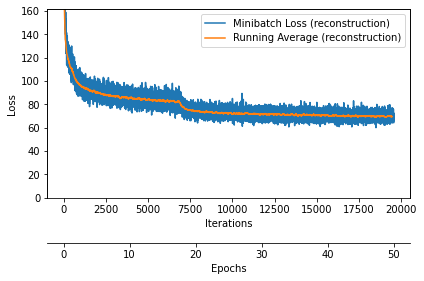

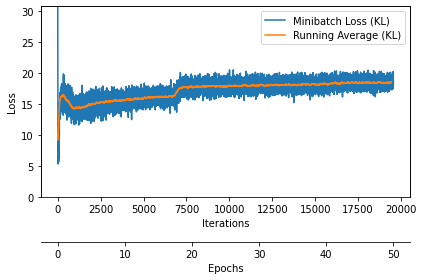

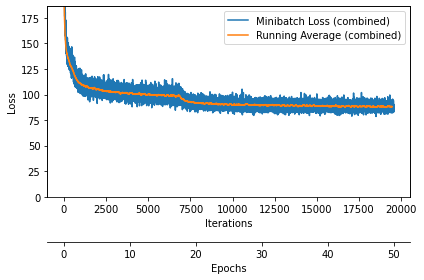

In [21]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
plt.show()

In [22]:
def plot_generated_images(data_loader, model, device, 
                          unnormalizer=None,
                          figsize=(20, 2.5), n_images=15, modeltype='autoencoder'):

    fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                             sharex=True, sharey=True, figsize=figsize)
    
    for batch_idx, (features, _) in enumerate(data_loader):
        
        features = features.to(device)

        color_channels = features.shape[1]
        image_height = features.shape[2]
        image_width = features.shape[3]
        
        with torch.no_grad():
            if modeltype == 'autoencoder':
                decoded_images = model(features)[:n_images]
            elif modeltype == 'VAE':
                encoded, z_mean, z_log_var, decoded_images = model(features)[:n_images]
            else:
                raise ValueError('`modeltype` not supported')

        orig_images = features[:n_images]
        break

    for i in range(n_images):
        for ax, img in zip(axes, [orig_images, decoded_images]):
            curr_img = img[i].detach().to(torch.device('cpu'))        
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax[i].imshow(curr_img)
            else:
                ax[i].imshow(curr_img.view((image_height, image_width)), cmap='binary')
                
                

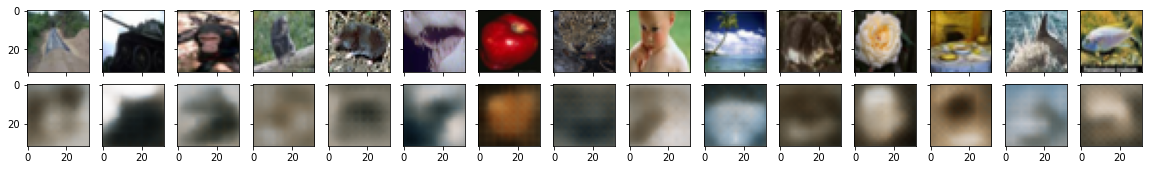

In [24]:
#unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
plot_generated_images(data_loader=train_loader,
                      model=model,
                      #unnormalizer=unnormalizer,
                      device='cuda:3',
                      modeltype='VAE')      

In [25]:
def plot_images_sampled_from_vae(model, device, latent_size, unnormalizer=None, num_images=10):

    with torch.no_grad():

        ##########################
        ### RANDOM SAMPLE
        ##########################    

        rand_features = torch.randn(num_images, latent_size).to(device)
        new_images = model.decoder(rand_features)
        color_channels = new_images.shape[1]
        image_height = new_images.shape[2]
        image_width = new_images.shape[3]

        ##########################
        ### VISUALIZATION
        ##########################

        image_width = 28

        fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(10, 2.5), sharey=True)
        decoded_images = new_images[:num_images]

        for ax, img in zip(axes, decoded_images):
            curr_img = img.detach().to(torch.device('cpu'))        
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax.imshow(curr_img)
            else:
                ax.imshow(curr_img.view((image_height, image_width)), cmap='binary') 

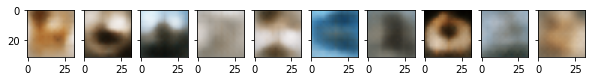

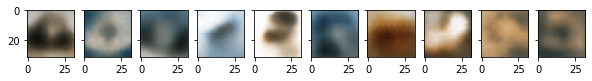

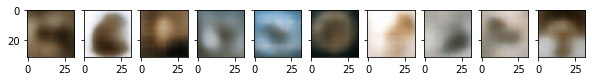

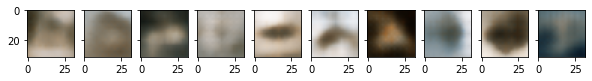

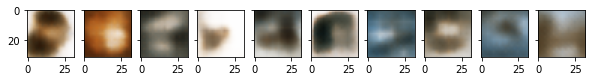

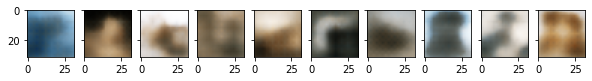

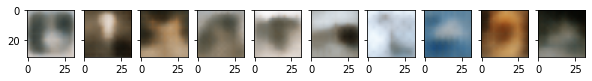

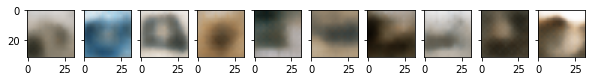

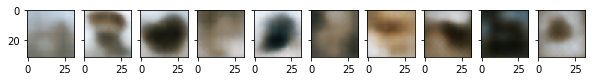

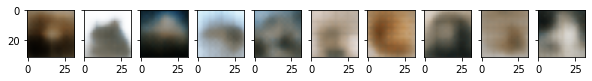

In [26]:
for i in range(10):
    plot_images_sampled_from_vae(model=model, device='cuda:3', latent_size=200)
    plt.show()

In [27]:
device = 'cuda:3'
model = model.to(device)
features = torch.zeros([10000, 256], device = 'cuda:3')
labels = torch.zeros([10000,],device = 'cuda:3')

for batch_idx, (X, y) in enumerate(test_loader):
    with torch.no_grad():
            X = X.to(device)
            y = y.to(device)

            feature = model.encoder(X)
            if batch_idx<25:
                features[batch_idx*128:(batch_idx+1)*128,:] = feature
                labels[batch_idx*128:(batch_idx+1)*128] = y
            else:
                features[batch_idx*128:(batch_idx)*128+100,:] = feature
                labels[batch_idx*128:(batch_idx)*128+100] = y
                

In [28]:
f, sis = forward_selection(features, labels,n = 100)#embedding, label, 100

  0%|          | 0/256 [00:00<?, ?it/s]

best SI:0.005799999926239252 for 107


  0%|          | 0/255 [00:00<?, ?it/s]

best SI:0.00699999975040555 for 139


  0%|          | 0/254 [00:00<?, ?it/s]

best SI:0.007799999788403511 for 1


  0%|          | 0/253 [00:00<?, ?it/s]

best SI:0.008700000122189522 for 188


  0%|          | 0/252 [00:00<?, ?it/s]

best SI:0.6789000034332275 for 240


  0%|          | 0/251 [00:00<?, ?it/s]

best SI:0.6812999844551086 for 47


  0%|          | 0/250 [00:00<?, ?it/s]

best SI:0.6819999814033508 for 61


  0%|          | 0/249 [00:00<?, ?it/s]

best SI:0.6819999814033508 for 2


  0%|          | 0/248 [00:00<?, ?it/s]

best SI:0.6829000115394592 for 243


  0%|          | 0/247 [00:00<?, ?it/s]

best SI:0.6843999624252319 for 168


  0%|          | 0/246 [00:00<?, ?it/s]

best SI:0.6848999857902527 for 3


  0%|          | 0/245 [00:00<?, ?it/s]

best SI:0.6848999857902527 for 51


  0%|          | 0/244 [00:00<?, ?it/s]

best SI:0.6850999593734741 for 68


  0%|          | 0/243 [00:00<?, ?it/s]

best SI:0.6861000061035156 for 171


  0%|          | 0/242 [00:00<?, ?it/s]

best SI:0.6865999698638916 for 93


  0%|          | 0/241 [00:00<?, ?it/s]

best SI:0.6868000030517578 for 169


  0%|          | 0/240 [00:00<?, ?it/s]

best SI:0.6872999668121338 for 111


  0%|          | 0/239 [00:00<?, ?it/s]

best SI:0.6879000067710876 for 0


  0%|          | 0/238 [00:00<?, ?it/s]

best SI:0.6881999969482422 for 22


  0%|          | 0/237 [00:00<?, ?it/s]

best SI:0.6886999607086182 for 200


  0%|          | 0/236 [00:00<?, ?it/s]

best SI:0.6886999607086182 for 11


  0%|          | 0/235 [00:00<?, ?it/s]

best SI:0.6883999705314636 for 233


  0%|          | 0/234 [00:00<?, ?it/s]

best SI:0.6886000037193298 for 83


  0%|          | 0/233 [00:00<?, ?it/s]

best SI:0.6886999607086182 for 212


  0%|          | 0/232 [00:00<?, ?it/s]

best SI:0.6890000104904175 for 86


  0%|          | 0/231 [00:00<?, ?it/s]

best SI:0.6890999674797058 for 102


  0%|          | 0/230 [00:00<?, ?it/s]

best SI:0.6890999674797058 for 163


  0%|          | 0/229 [00:00<?, ?it/s]

best SI:0.6886999607086182 for 112


  0%|          | 0/228 [00:00<?, ?it/s]

best SI:0.6886000037193298 for 223


  0%|          | 0/227 [00:00<?, ?it/s]

best SI:0.6890000104904175 for 186


  0%|          | 0/226 [00:00<?, ?it/s]

best SI:0.689799964427948 for 151


  0%|          | 0/225 [00:00<?, ?it/s]

best SI:0.6904000043869019 for 32


  0%|          | 0/224 [00:00<?, ?it/s]

best SI:0.6905999779701233 for 210


  0%|          | 0/223 [00:00<?, ?it/s]

best SI:0.6908000111579895 for 156


  0%|          | 0/222 [00:00<?, ?it/s]

best SI:0.6905999779701233 for 241


  0%|          | 0/221 [00:00<?, ?it/s]

best SI:0.6904999613761902 for 8


  0%|          | 0/220 [00:00<?, ?it/s]

best SI:0.6904999613761902 for 234


  0%|          | 0/219 [00:00<?, ?it/s]

best SI:0.6904000043869019 for 9


  0%|          | 0/218 [00:00<?, ?it/s]

best SI:0.6905999779701233 for 73


  0%|          | 0/217 [00:00<?, ?it/s]

best SI:0.6906999945640564 for 114


  0%|          | 0/216 [00:00<?, ?it/s]

best SI:0.6908000111579895 for 137


  0%|          | 0/215 [00:00<?, ?it/s]

best SI:0.6908000111579895 for 17


  0%|          | 0/214 [00:00<?, ?it/s]

best SI:0.6912999749183655 for 219


  0%|          | 0/213 [00:00<?, ?it/s]

best SI:0.6913999915122986 for 36


  0%|          | 0/212 [00:00<?, ?it/s]

best SI:0.69159996509552 for 75


  0%|          | 0/211 [00:00<?, ?it/s]

best SI:0.6913999915122986 for 37


  0%|          | 0/210 [00:00<?, ?it/s]

best SI:0.691100001335144 for 208


  0%|          | 0/209 [00:00<?, ?it/s]

best SI:0.6908000111579895 for 213


  0%|          | 0/208 [00:00<?, ?it/s]

best SI:0.6913999915122986 for 145


  0%|          | 0/207 [00:00<?, ?it/s]

best SI:0.6912999749183655 for 150


  0%|          | 0/206 [00:00<?, ?it/s]

best SI:0.6911999583244324 for 65


  0%|          | 0/205 [00:00<?, ?it/s]

best SI:0.691100001335144 for 235


  0%|          | 0/204 [00:00<?, ?it/s]

best SI:0.6911999583244324 for 97


  0%|          | 0/203 [00:00<?, ?it/s]

best SI:0.6912999749183655 for 38


  0%|          | 0/202 [00:00<?, ?it/s]

best SI:0.691100001335144 for 50


  0%|          | 0/201 [00:00<?, ?it/s]

best SI:0.6905999779701233 for 62


  0%|          | 0/200 [00:00<?, ?it/s]

best SI:0.6902999877929688 for 154


  0%|          | 0/199 [00:00<?, ?it/s]

best SI:0.6902999877929688 for 167


  0%|          | 0/198 [00:00<?, ?it/s]

best SI:0.6904999613761902 for 174


  0%|          | 0/197 [00:00<?, ?it/s]

best SI:0.6905999779701233 for 70


  0%|          | 0/196 [00:00<?, ?it/s]

best SI:0.6908999681472778 for 201


  0%|          | 0/195 [00:00<?, ?it/s]

best SI:0.6908000111579895 for 179


  0%|          | 0/194 [00:00<?, ?it/s]

best SI:0.6905999779701233 for 199


  0%|          | 0/193 [00:00<?, ?it/s]

best SI:0.6908999681472778 for 27


  0%|          | 0/192 [00:00<?, ?it/s]

best SI:0.6913999915122986 for 71


  0%|          | 0/191 [00:00<?, ?it/s]

best SI:0.6915000081062317 for 158


  0%|          | 0/190 [00:00<?, ?it/s]

best SI:0.6913999915122986 for 125


  0%|          | 0/189 [00:00<?, ?it/s]

best SI:0.6911999583244324 for 147


  0%|          | 0/188 [00:00<?, ?it/s]

best SI:0.6908999681472778 for 82


  0%|          | 0/187 [00:00<?, ?it/s]

best SI:0.6908999681472778 for 25


  0%|          | 0/186 [00:00<?, ?it/s]

best SI:0.691100001335144 for 48


  0%|          | 0/185 [00:00<?, ?it/s]

best SI:0.691100001335144 for 124


  0%|          | 0/184 [00:00<?, ?it/s]

best SI:0.6911999583244324 for 146


  0%|          | 0/183 [00:00<?, ?it/s]

best SI:0.6909999847412109 for 211


  0%|          | 0/182 [00:00<?, ?it/s]

best SI:0.69159996509552 for 126


  0%|          | 0/181 [00:00<?, ?it/s]

best SI:0.6918999552726746 for 193


  0%|          | 0/180 [00:00<?, ?it/s]

best SI:0.6916999816894531 for 189


  0%|          | 0/179 [00:00<?, ?it/s]

best SI:0.69159996509552 for 214


  0%|          | 0/178 [00:00<?, ?it/s]

best SI:0.6916999816894531 for 244


  0%|          | 0/177 [00:00<?, ?it/s]

best SI:0.6918999552726746 for 177


  0%|          | 0/176 [00:00<?, ?it/s]

best SI:0.6920999884605408 for 44


  0%|          | 0/175 [00:00<?, ?it/s]

best SI:0.6922000050544739 for 203


  0%|          | 0/174 [00:00<?, ?it/s]

best SI:0.6922000050544739 for 254


  0%|          | 0/173 [00:00<?, ?it/s]

best SI:0.6920999884605408 for 110


  0%|          | 0/172 [00:00<?, ?it/s]

best SI:0.6918999552726746 for 255


  0%|          | 0/171 [00:00<?, ?it/s]

best SI:0.6915000081062317 for 95


  0%|          | 0/170 [00:00<?, ?it/s]

best SI:0.6915000081062317 for 162


  0%|          | 0/169 [00:00<?, ?it/s]

best SI:0.6915000081062317 for 130


  0%|          | 0/168 [00:00<?, ?it/s]

best SI:0.6916999816894531 for 81


  0%|          | 0/167 [00:00<?, ?it/s]

best SI:0.6916999816894531 for 215


  0%|          | 0/166 [00:00<?, ?it/s]

best SI:0.69159996509552 for 136


  0%|          | 0/165 [00:00<?, ?it/s]

best SI:0.6913999915122986 for 94


  0%|          | 0/164 [00:00<?, ?it/s]

best SI:0.6913999915122986 for 170


  0%|          | 0/163 [00:00<?, ?it/s]

best SI:0.6913999915122986 for 119


  0%|          | 0/162 [00:00<?, ?it/s]

best SI:0.6912999749183655 for 92


  0%|          | 0/161 [00:00<?, ?it/s]

best SI:0.6915000081062317 for 45


  0%|          | 0/160 [00:00<?, ?it/s]

best SI:0.6915000081062317 for 216


  0%|          | 0/159 [00:00<?, ?it/s]

best SI:0.6917999982833862 for 202


  0%|          | 0/158 [00:00<?, ?it/s]

best SI:0.6918999552726746 for 57


  0%|          | 0/157 [00:00<?, ?it/s]

best SI:0.6919999718666077 for 28


  0%|          | 0/156 [00:00<?, ?it/s]

best SI:0.6919999718666077 for 14
best features obtaied


In [29]:
SI_evaluation(features, labels)

tensor(0.6832, device='cuda:3')

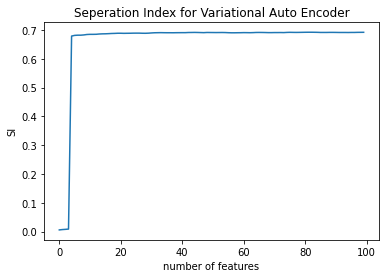

In [30]:
plt.plot(sis)
plt.title("Seperation Index for Variational Auto Encoder")
plt.ylabel('SI')
plt.xlabel('number of features');